<a href="https://colab.research.google.com/github/Badslam/COVID-19CNN-Thesis/blob/main/rg_covid_inceptionv2resnet_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [1]:
!pip install openpyxl
!pip install imutils
!pip install kaggle
!pip install patool

     |████████████████████████████████| 77 kB 4.0 MB/s 


In [2]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os
import patoolib

print(tf.__version__)

2.5.0


In [3]:
tf.random.set_seed(666)

# Set Output Class

In [4]:
# Set output class
output_class = 3 # 2/3 class
if output_class > 3 or output_class < 2:
    print("Undefined")

# Dataset Preparation

In [5]:
if not os.path.exists(os.getcwd() + "/kaggle.json"):
    files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download tawsifurrahman/covid19-radiography-database

# extract x-ray dataset
if os.path.exists(os.getcwd() + "/input"):
    shutil.rmtree(os.getcwd() + "/input")
patoolib.extract_archive(os.getcwd() + "/covid19-radiography-database.zip", outdir = os.getcwd() + "/input/covid19-radiography-database")
os.remove(os.getcwd() + "/covid19-radiography-database.zip")

Saving kaggle.json to kaggle.json
100% 744M/745M [00:09<00:00, 50.8MB/s]
100% 745M/745M [00:09<00:00, 81.9MB/s]
patool: Extracting /content/covid19-radiography-database.zip ...
patool: running /usr/bin/7z x -o/content/input/covid19-radiography-database -- /content/covid19-radiography-database.zip
patool: ... /content/covid19-radiography-database.zip extracted to `/content/input/covid19-radiography-database'.


In [6]:
df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx", engine = "openpyxl")
url = df["URL"].unique()
print("List URL Dataset Normal")
print(url)

df_normal = df["FILE NAME"]
#df_normal = df[(df["URL"] == url[1])]["FILE NAME"]

list_normal = np.array(df_normal)
list_normal[:] = [s.capitalize() for s in list_normal]

print("List Dataset Train and Validation Normal")
print(list_normal)

df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx", engine = "openpyxl")
url = df["URL"].unique()
print("List URL Dataset COVID")
print(url)

df_covid = df["FILE NAME"]
#df_covid = df[(df["URL"] == url[0]) | (df["URL"] == url[1]) | (df["URL"] == url[2]) | (df["URL"] == url[3]) | (df["URL"] == url[4])]["FILE NAME"]

list_covid = np.array(df_covid)

print("List Dataset Train and Validation COVID")
print(list_covid)

if output_class == 3:
    df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx", engine = "openpyxl")
    url = df["URL"].unique()
    print("List URL Dataset Pneumonia")
    print(url)

    df_pneumonia = df["FILE NAME"]

    list_pneumonia = np.array(df_pneumonia)
    
    print("List Dataset Train and Validation Pneumonia")
    print(list_pneumonia)

List URL Dataset Normal
['https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data'
 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia']
List Dataset Train and Validation Normal
['Normal-1' 'Normal-2' 'Normal-3' ... 'Normal-10190' 'Normal-10191'
 'Normal-10192']
List URL Dataset COVID
['https://sirm.org/category/senza-categoria/covid-19/'
 'https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png'
 'https://eurorad.org' 'https://github.com/armiro/COVID-CXNet'
 'https://github.com/ieee8023/covid-chestxray-dataset'
 'https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711']
List Dataset Train and Validation COVID
['COVID-1' 'COVID-2' 'COVID-3' ... 'COVID-3614' 'COVID-3615' 'COVID-3616']
List URL Dataset Pneumonia
['https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia']
List Dataset Train and Validation Pneumonia
['Viral Pneumonia-1' 'Viral Pneumonia-2' 'Viral Pneumonia-3' ...
 'Viral Pneumonia-1343' 'Viral Pneumonia-1

In [7]:
# Create directory
if os.path.exists(os.getcwd() + "/Dataset"):
    shutil.rmtree(os.getcwd() + "/Dataset")
os.mkdir(os.getcwd() + "/Dataset")
os.mkdir(os.getcwd() + "/Dataset/Train")
os.mkdir(os.getcwd() + "/Dataset/Validation")
os.mkdir(os.getcwd() + "/Dataset/Train/Normal")
os.mkdir(os.getcwd() + "/Dataset/Validation/Normal")
os.mkdir(os.getcwd() + "/Dataset/Train/COVID")
os.mkdir(os.getcwd() + "/Dataset/Validation/COVID")
if output_class == 3:
    os.mkdir(os.getcwd() + "/Dataset/Train/Pneumonia")
    os.mkdir(os.getcwd() + "/Dataset/Validation/Pneumonia")


dataset_covid = len(list_covid)
dataset_normal = len(list_normal)

dataset_covid = [i for i in range(dataset_covid)]
dataset_normal = [i for i in range(dataset_normal)]
if output_class == 3:
    dataset_covid = len(list_covid)
    dataset_normal = len(list_normal)
    dataset_pneumonia = len(list_pneumonia)
    dataset_covid = [i for i in range(dataset_covid)]
    dataset_normal = [i for i in range(dataset_normal)]
    dataset_pneumonia = [i for i in range(dataset_pneumonia)]

### kFold Validation
k = 1 # Change fold here
Fold = 5 # Change if validation split not 0.2 (1/5)
###

n = len(dataset_normal)
m = int((1/Fold)*len(dataset_normal))
index = n - int(k*n/Fold)
# Normal Validation Dataset
for x in dataset_normal[index:index + m]:
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/{}{}".format(list_normal[x], ".png"), 
                    os.getcwd() + "/Dataset/Validation/Normal/{}{}".format(list_normal[x], ".png"))

# Normal Train Dataset
del dataset_normal[index:index + m]
for x in dataset_normal:
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/{}{}".format(list_normal[x], ".png"), 
                    os.getcwd() + "/Dataset/Train/Normal/{}{}".format(list_normal[x], ".png"))

n = len(dataset_covid)
m = int((1/Fold)*len(dataset_covid))
index = n - int(k*n/Fold)
# Covid Validation Dataset
for x in dataset_covid[index:index + m]:
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/{}{}".format(list_covid[x], ".png"), 
                    os.getcwd() + "/Dataset/Validation/COVID/{}{}".format(list_covid[x], ".png"))

# Covid Train Dataset
del dataset_covid[index:index + m]
for x in dataset_covid:
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/{}{}".format(list_covid[x], ".png"), 
                    os.getcwd() + "/Dataset/Train/COVID/{}{}".format(list_covid[x], ".png"))

if output_class == 3:
    n = len(dataset_pneumonia)
    m = int((1/Fold)*len(dataset_pneumonia))
    index = n - int(k*n/Fold)
    # Pneumonia Validation Dataset
    for x in dataset_pneumonia[index:index + m]:
        shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/{}{}".format(list_pneumonia[x], ".png"), 
                        os.getcwd() + "/Dataset/Validation/Pneumonia/{}{}".format(list_pneumonia[x], ".png"))
    
    # Pneumonia Train Dataset
    del dataset_pneumonia[index:index + m]
    for x in dataset_pneumonia:
        shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/{}{}".format(list_pneumonia[x], ".png"), 
                        os.getcwd() + "/Dataset/Train/Pneumonia/{}{}".format(list_pneumonia[x], ".png"))

print("Dataset Train")
print("Normal :", len(os.listdir(os.getcwd() + "/Dataset/Train/Normal")))
print("COVID :", len(os.listdir(os.getcwd() + "/Dataset/Train/COVID")))
if output_class == 3:
    print("Pneumonia :", len(os.listdir(os.getcwd() + "/Dataset/Train/Pneumonia")))

print("Dataset Validation")
print("Normal :", len(os.listdir(os.getcwd() + "/Dataset/Validation/Normal")))
print("COVID :", len(os.listdir(os.getcwd() + "/Dataset/Validation/COVID")))
if output_class == 3:
    print("Pneumonia :", len(os.listdir(os.getcwd() + "/Dataset/Validation/Pneumonia")))

Dataset Train
Normal : 8154
COVID : 2893
Pneumonia : 1076
Dataset Validation
Normal : 2038
COVID : 723
Pneumonia : 269


# Plot X-Rays

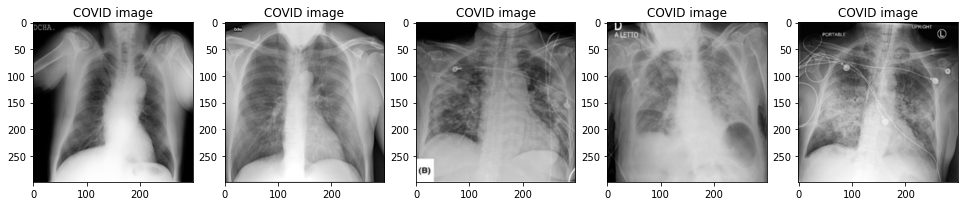

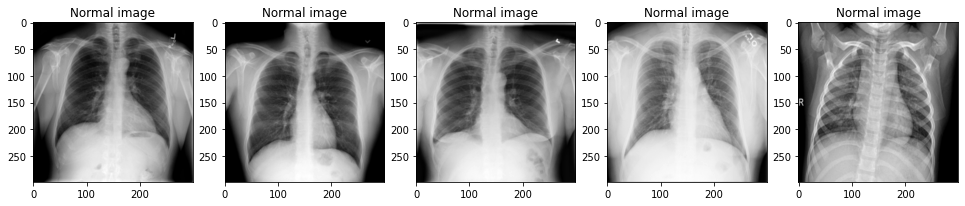

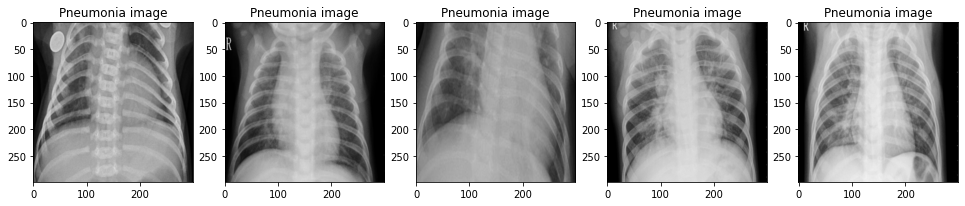

In [8]:
directory = ["COVID", "Normal"]
if output_class == 3:
    directory = ["COVID", "Normal", "Pneumonia"]
for each in directory:
    plt.figure(figsize = (20, 10))
    currentFolder = os.getcwd() + "/Dataset/Train/" + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img=mpimg.imread(fullpath)
        plt.subplot(3, 6, i+1)
        title = each + " image"
        plt.title(title)
        plt.imshow(img, cmap = "gray")

# Data Preprocessing

In [9]:
# set the initial learning rate, number of epochs, batch size and img dimension
learning_rate = 1e-5
epochs = 50
batch_size = 32
img_width, img_height = 224, 224
train_path = os.getcwd() + "/Dataset/Train"
validation_path = os.getcwd() + "/Dataset/Validation"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    fill_mode = "nearest",
    validation_split = 0.2)
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

if output_class == 2:
    # set as training data
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = "binary")
    # set as validation data
    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = "binary",
        shuffle = False)
    
elif output_class == 3:
    # set as training data
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = "categorical")
    # set as validation data
    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = "categorical",
        shuffle = False)
    
else:
    print("Undefined")

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


# Build and Training Model

In [10]:
'''
# create model
if output_class == 2:
    model = tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", input_shape = (img_width, img_height, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),

        # Block 2
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),
    
        # Block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),
    
        # Block 4
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),
    
        # Block 5
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),

        # Block 6
        tf.keras.layers.AveragePooling2D((4, 4), padding = "same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")],
        name = "CNN_Binary_Classification")
    
    # compile our model
    model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
        
elif output_class == 3:
    model = tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", input_shape = (img_width, img_height, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),

        # Block 2
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),
    
        # Block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),
    
        # Block 4
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),
    
        # Block 5
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),

        # Block 6
        tf.keras.layers.AveragePooling2D((4, 4), padding = "same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation = "softmax")],
        name = "CNN_Multiclass_Classification")
    
    # compile our model
    model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
        
else:
    print("Undefined")

model.summary()
'''

'\n# create model\nif output_class == 2:\n    model = tf.keras.Sequential([\n        # Block 1\n        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", input_shape = (img_width, img_height, 3)),\n        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),\n\n        # Block 2\n        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),\n        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),\n    \n        # Block 3\n        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),\n        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.MaxPooling2D(

In [11]:
'''
if output_class == 2:
    tf.keras.applications.vgg16.trainable = True
    model = tf.keras.Sequential([
        tf.keras.applications.vgg16.VGG16(input_shape = (img_width, img_height, 3), weights = None, include_top = False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid")],
        name = "VGG16_Binary_Classification")

    model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])

elif output_class == 3:
    tf.keras.applications.vgg16.trainable = True
    model = tf.keras.Sequential([
        tf.keras.applications.vgg16.VGG16(input_shape = (img_width, img_height, 3), weights = None, include_top = False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.Dense(3, activation = "softmax")],
        name = "VGG16_Multiclass_Classification")

    model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

else:
    print("Undefined")

model.summary()
'''

'\nif output_class == 2:\n    tf.keras.applications.vgg16.trainable = True\n    model = tf.keras.Sequential([\n        tf.keras.applications.vgg16.VGG16(input_shape = (img_width, img_height, 3), weights = None, include_top = False),\n        tf.keras.layers.Flatten(),\n        tf.keras.layers.Dense(4096, activation = "relu"),\n        tf.keras.layers.Dense(4096, activation = "relu"),\n        tf.keras.layers.Dense(1, activation = "sigmoid")],\n        name = "VGG16_Binary_Classification")\n\n    model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),\n                  loss = "binary_crossentropy",\n                  metrics = ["accuracy"])\n\nelif output_class == 3:\n    tf.keras.applications.vgg16.trainable = True\n    model = tf.keras.Sequential([\n        tf.keras.applications.vgg16.VGG16(input_shape = (img_width, img_height, 3), weights = None, include_top = False),\n        tf.keras.layers.Flatten(),\n        tf.keras.layers.Dense(4096, acti

In [12]:
'''
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("accuracy") > .99):
            print("\nAccuracy Reached > .99!")
            self.model.stop_training = True    
callbacks = myCallback()

result = model.fit(train_generator,
                   steps_per_epoch = train_generator.samples // batch_size, 
                   validation_data = validation_generator,
                   validation_steps = validation_generator.samples // batch_size,
                   #callbacks=[callbacks],
                   epochs = epochs)
'''

'\nclass myCallback(tf.keras.callbacks.Callback):\n    def on_epoch_end(self, epoch, logs={}):\n        if (logs.get("accuracy") > .99):\n            print("\nAccuracy Reached > .99!")\n            self.model.stop_training = True    \ncallbacks = myCallback()\n\nresult = model.fit(train_generator,\n                   steps_per_epoch = train_generator.samples // batch_size, \n                   validation_data = validation_generator,\n                   validation_steps = validation_generator.samples // batch_size,\n                   #callbacks=[callbacks],\n                   epochs = epochs)\n'

# TransferLearning Model Experiment

In [13]:
tf.keras.applications.inception_resnet_v2.trainable = False
model = tf.keras.Sequential([
        tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape = (img_width, img_height, 3), weights = None, include_top = False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.Dense(3, activation = "softmax")],
        name = "InceptionResnetV2_Categorical_Classification")

model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

In [14]:
# view the structure of the model
model.summary()

Model: "InceptionResnetV2_Categorical_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              157290496 
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12291     
Total params: 228,420,835
Trainable params: 228,360,291
Non-trainable params: 60,544
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

result = model.fit(train_generator,
                   steps_per_epoch = train_generator.samples // batch_size, 
                   validation_data = validation_generator,
                   validation_steps = validation_generator.samples // batch_size,
                   callbacks=[monitor],
                   epochs = epochs)

Epoch 1/50
378/378 [==============================] - 310s 691ms/step - loss: 0.3503 - accuracy: 0.8614 - val_loss: 2.2973 - val_accuracy: 0.2443
Epoch 2/50
378/378 [==============================] - 257s 679ms/step - loss: 0.1838 - accuracy: 0.9313 - val_loss: 0.1802 - val_accuracy: 0.9305
Epoch 3/50
378/378 [==============================] - 256s 678ms/step - loss: 0.1475 - accuracy: 0.9462 - val_loss: 0.1881 - val_accuracy: 0.9289
Epoch 4/50
378/378 [==============================] - 258s 681ms/step - loss: 0.1164 - accuracy: 0.9581 - val_loss: 0.1551 - val_accuracy: 0.9438
Epoch 5/50
378/378 [==============================] - 257s 679ms/step - loss: 0.0982 - accuracy: 0.9642 - val_loss: 0.2480 - val_accuracy: 0.9192
Epoch 6/50
378/378 [==============================] - 258s 682ms/step - loss: 0.0800 - accuracy: 0.9709 - val_loss: 0.1257 - val_accuracy: 0.9541
Epoch 7/50
378/378 [==============================] - 257s 680ms/step - loss: 0.0713 - accuracy: 0.9731 - val_loss: 0.1432 -

In [16]:
tf.keras.applications.inception_resnet_v2.trainable = False

epochs = 50
result = model.fit(train_generator,
                   steps_per_epoch = train_generator.samples // batch_size, 
                   validation_data = validation_generator,
                   validation_steps = validation_generator.samples // batch_size,
                   callbacks=[monitor],
                   epochs = epochs)

Epoch 1/50
378/378 [==============================] - 256s 677ms/step - loss: 0.0711 - accuracy: 0.9747 - val_loss: 0.1992 - val_accuracy: 0.9425
Epoch 2/50
378/378 [==============================] - 256s 678ms/step - loss: 0.0619 - accuracy: 0.9769 - val_loss: 0.1440 - val_accuracy: 0.9584
Epoch 3/50
378/378 [==============================] - 255s 675ms/step - loss: 0.0478 - accuracy: 0.9821 - val_loss: 0.1513 - val_accuracy: 0.9581
Epoch 4/50
378/378 [==============================] - 256s 675ms/step - loss: 0.0426 - accuracy: 0.9850 - val_loss: 0.1633 - val_accuracy: 0.9551
Epoch 5/50
378/378 [==============================] - 255s 675ms/step - loss: 0.0377 - accuracy: 0.9875 - val_loss: 0.1066 - val_accuracy: 0.9658
Epoch 6/50
378/378 [==============================] - 256s 677ms/step - loss: 0.0381 - accuracy: 0.9869 - val_loss: 0.1874 - val_accuracy: 0.9451
Epoch 7/50
378/378 [==============================] - 256s 677ms/step - loss: 0.0359 - accuracy: 0.9876 - val_loss: 0.1393 -

# Plot Result

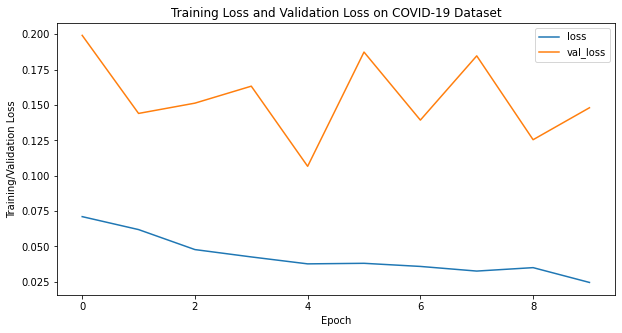

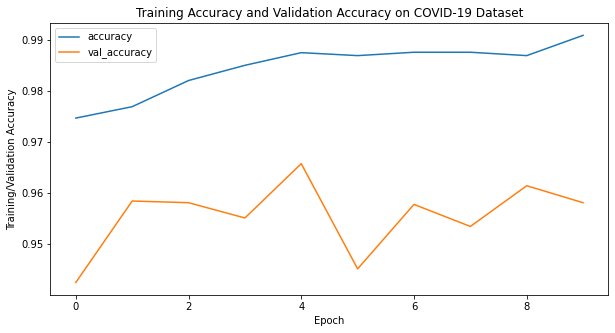

In [17]:
# Plotting train_loss vs val_loss
plt.figure(figsize = (10, 5))
plt.plot(result.history["loss"], label = "loss")
plt.plot(result.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize = (10, 5))
plt.plot(result.history["accuracy"], label = "accuracy")
plt.plot(result.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

# Evaluation

In [18]:
print(model.evaluate(validation_generator))

95/95 [==============================] - 19s 201ms/step - loss: 0.1059 - accuracy: 0.9660
[0.10593196004629135, 0.9660065770149231]


In [19]:
#Prediction:
target_names = ["COVID", "Normal"]
if output_class == 3:
    target_names = ["COVID", "Normal", "Pneumonia"]

if output_class == 2:
    predict = model.predict_classes(validation_generator)
elif output_class == 3:
    predict = model.predict(validation_generator)
    predict = np.argmax(predict, axis=1)
else:
    print("Undefined")
    
print("Confusion Matrix")
cm = confusion_matrix(validation_generator.classes, predict)
print(cm)
    
# show the accuracy, sensitivity, and specificity  
total = sum(sum(cm))  
if output_class == 2:
    acc = (cm[0][0] + cm[1][1]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
elif output_class == 3:
    acc = (cm[0][0] + cm[1][1] + cm[2][2]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
    sensitivity = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print("{} sensitivity: {:.4f}".format(target_names[2], sensitivity))
else:
    print("Undefined")

print("Classification Report")
if output_class == 2:
    print(classification_report(validation_generator.classes, predict, target_names = target_names))
elif output_class == 3:
    print(classification_report(validation_generator.classes, predict, target_names = target_names))
else:
    print("Undefined")

Confusion Matrix
[[ 679   41    3]
 [  48 1990    0]
 [   0   11  258]]
acc: 0.9660
COVID sensitivity: 0.9391
Normal sensitivity: 0.9764
Pneumonia sensitivity: 0.9591
Classification Report
              precision    recall  f1-score   support

       COVID       0.93      0.94      0.94       723
      Normal       0.97      0.98      0.98      2038
   Pneumonia       0.99      0.96      0.97       269

    accuracy                           0.97      3030
   macro avg       0.97      0.96      0.96      3030
weighted avg       0.97      0.97      0.97      3030



In [20]:
print("Loss")
print(result.history["loss"])
print("Accuracy")
print(result.history["accuracy"])
print("Val_Loss")
print(result.history["val_loss"])
print("Val_Accuracy")
print(result.history["val_accuracy"])

Loss
[0.07106351852416992, 0.06190647929906845, 0.04777087643742561, 0.042573049664497375, 0.03766852989792824, 0.038060855120420456, 0.03585320711135864, 0.032572731375694275, 0.03500109538435936, 0.024531809613108635]
Accuracy
[0.9746919274330139, 0.9769249558448792, 0.982052743434906, 0.9850301742553711, 0.987511396408081, 0.9869324564933777, 0.9875940680503845, 0.9875940680503845, 0.9869324564933777, 0.990902304649353]
Val_Loss
[0.19922693073749542, 0.1440255045890808, 0.15129505097866058, 0.1632988005876541, 0.10663745552301407, 0.18741260468959808, 0.13931460678577423, 0.18472245335578918, 0.1254449039697647, 0.1480431854724884]
Val_Accuracy
[0.9424867033958435, 0.9584441781044006, 0.9581117033958435, 0.9551196694374084, 0.9657579660415649, 0.9451462626457214, 0.9577792286872864, 0.9534574747085571, 0.9614361524581909, 0.9581117033958435]


In [21]:
model.save("model_IR2.h5")

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
shutil.move("/content/model_IR2.h5", "/content/drive/MyDrive/Nima_Solusi_Teknologi")

'/content/drive/MyDrive/Nima_Solusi_Teknologi/model_IR2.h5'